In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from Network import *
from Task import *
from HelperFunctions import *
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import scipy.interpolate
import numpy as np

device = None

In [2]:
task = 'trace' #'trace_search' 'search_trace' #'trace'
curve_length = 6
grid_size = 6

# Behaviour of the network

## Performance

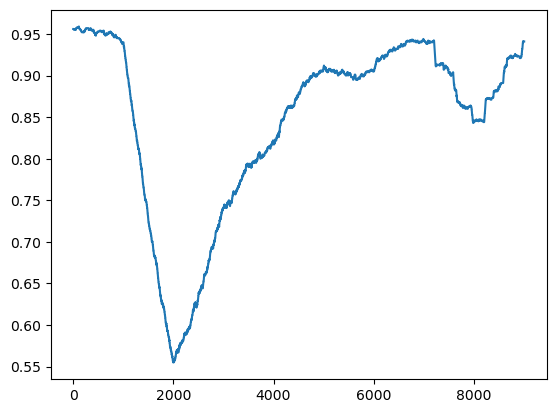

In [7]:
performance = np.load(os.path.join('results','performance_'+task+'_'+str(curve_length)+'.npy'))

plt.figure()
plt.plot(np.convolve(performance, np.ones(1000), 'valid') / 1000)

## Generalization

(0.5, 1.0)

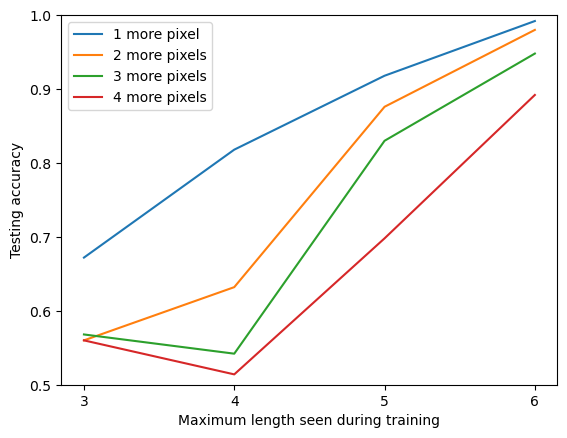

In [13]:
generalisation = np.load(os.path.join('results','generalisation_'+task+'_'+str(curve_length)+'.npy'))

plt.plot(np.diag(generalisation,0))
plt.plot(np.diag(generalisation,1))
plt.plot(np.diag(generalisation,2))
plt.plot(np.diag(generalisation,3))


plt.legend(['1 more pixel','2 more pixels','3 more pixels','4 more pixels'])
plt.xlabel('Maximum length seen during training')
plt.xticks([i for i in range(curve_length-2)],[i for i in range(3,curve_length+1)])
plt.ylabel('Testing accuracy')
plt.ylim([0.5,1])


## Results

In [3]:
neural_activations = open_base(os.path.join('results','network_activations_'+task+'_'+str(curve_length)))


target_activations_recurrent = neural_activations['target_activations'][0][:,:3,:,:,:]
distractor_activations_recurrent = neural_activations['distractor_activations'][0][:,:3,:,:,:]

target_activations_feedforward = neural_activations['target_activations'][0][:,3,:,:,:]
distractor_activations_feedforward = neural_activations['distractor_activations'][0][:,3,:,:,:]

target_activations_output = neural_activations['target_activations'][0][:,4,:,:,:]
distractor_activations_output = neural_activations['distractor_activations'][0][:,4,:,:,:]

### Timecourse of modulation

#### Recurrent layers

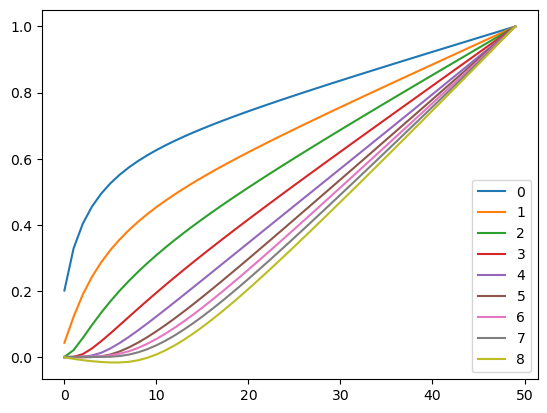

In [30]:
plt.figure()
TD = target_activations_recurrent - distractor_activations_recurrent

normalized_TD = np.nanmean(TD,axis = (0,1,2))
normalized_TD = normalized_TD/np.expand_dims(np.max(normalized_TD,axis = 1),axis = 1)
plt.plot(normalized_TD.T)

legend = [str(i) for i in range(curve_length)]
if task != 'trace':
    legend.append('marker')
plt.legend(legend)



#### Output layer

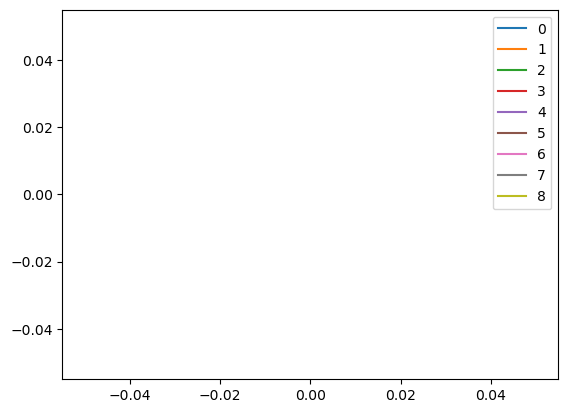

In [31]:
plt.figure()
TD = target_activations_output - distractor_activations_output

normalized_TD = np.nanmean(TD,axis = (0,1))
normalized_TD = normalized_TD/np.expand_dims(np.max(normalized_TD,axis = 1),axis = 1)
plt.plot(normalized_TD.T)

legend = [str(i) for i in range(curve_length)]
if task != 'trace':
    legend.append('marker')
plt.legend(legend)


### Individual pixel

In [ ]:
sns.set(rc={'figure.figsize':(10,6)})
plt.plot(target_activations_recurrent[100,1,0,5,:])
plt.plot(distractor_activations_recurrent[100,1,0,5,:])
plt.plot(target_activations_feedforward[100,0,5,:])
plt.plot(distractor_activations_feedforward[100,0,5,:])
plt.ylim([0,0.5])

### Sign of modulation

(array([0.1189149 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00743218,
        0.12820513, 0.07060572, 0.13749535, 0.26941657, 0.31400966,
        0.29542921, 0.35302861, 0.70048309, 1.12783352, 1.47714604]),
 array([-2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,
         0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <BarContainer object of 20 artists>)

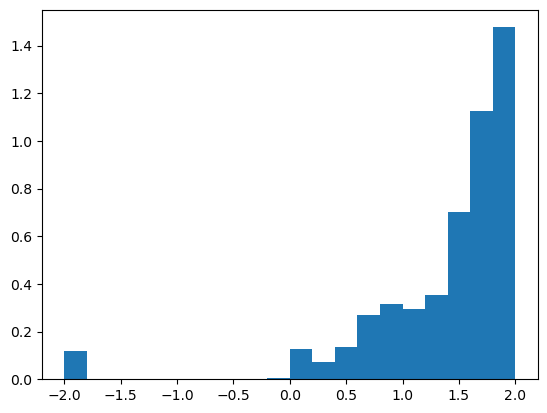

In [33]:
modulation = (target_activations_recurrent - distractor_activations_recurrent) / ((target_activations_recurrent + distractor_activations_recurrent) / 2)

dprime = modulation[:,:,:,:,-1].flatten()
plt.hist(dprime,density=True,bins=20)


### Cumulative modulation latency at individual recording sites

In [10]:
operation_2

'trace'

2
7


Text(0.5, 0, 'Modulation latency')

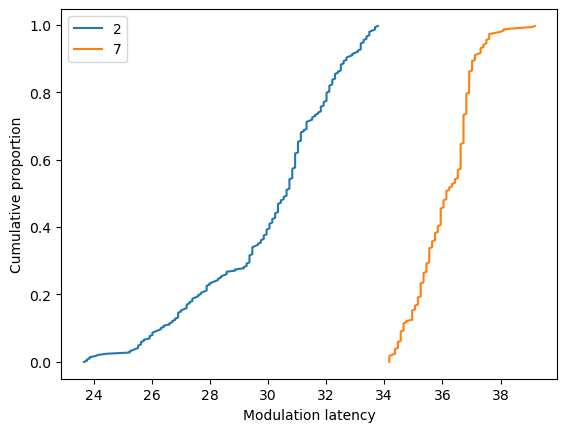

In [14]:
if task == 'trace':
    operation_1 = operation_2 = 'trace'
else:
    operation_1 = 'trace'
    operation_2 = 'search'


TD = target_activations_recurrent - distractor_activations_recurrent


timesteps_1 = latency_operation(TD,operation_1,task,curve_length,criterion=0.7,dur = 50,position_on_curve = 2)
X_1 = np.sort(timesteps_search)
F_1 = np.array(range(len(timesteps_search)))/float(len(timesteps_search))

timesteps_2 = latency_operation(TD,operation_2,task,curve_length,criterion=0.7,dur=50,position_on_curve = 7)
X_2 = np.sort(timesteps_trace)
F_2 = np.array(range(len(timesteps_trace)))/float(len(timesteps_trace))

plt.plot(X_1, F_1)
plt.plot(X_2, F_2)
if task == 'trace':
    plt.legend(['2','7'])
else:
    plt.legend([operation_1,operation_2])
plt.ylabel('Cumulative proportion')
plt.xlabel('Modulation latency')


In [157]:
operation = 'trace'
CurveLength = 9
number_interpolation_points=500
dur=50
criterion=0.5
TD = Target[:,:,:,:,:,1] - Distractor[:,:,:,:,:,1]
if operation == 'search':
    neurons = [0,1] #first two neurons correspond to the search operation
    position_on_curve = -1 #we arbitrarily put them at the end of the curve_length dimension in TD
elif operation == 'trace':
    neurons = np.arange(2,TD.shape[0])
else:
    raise Exception("Operation is either search or trace")

if operation == 'trace' and TASK == 'searchtrace':
    position_on_curve = 0 #in the search then trace task, the trace follows the search
elif operation == 'trace' and TASK == 'tracesearch':
    position_on_curve = CurveLength - 1 #in the trace then searcg task, the trace precedes the search
elif TASK == 'trace':
    position_on_curve = 0


#Interpolating the response curve to have non-integer latency of modulation   
normalized_TD = TD[neurons,:,:,position_on_curve,:]/np.expand_dims(np.max(np.abs(TD[neurons,:,:,position_on_curve,:]),axis = -1),axis=-1)
interpollation_function = scipy.interpolate.interp1d(np.arange(0,dur), normalized_TD, kind='linear',axis=-1)
interpolated_normalized_TD = interpollation_function(np.linspace(0, dur-1, num=number_interpolation_points))
smoothed_interpolated_normalized_TD = uniform_filter1d(interpolated_normalized_TD, size=100,axis = -1)


#Modulation condition: criterion * difference between beginning and end
condition = np.abs(np.max(smoothed_interpolated_normalized_TD,axis=-1)-np.min(smoothed_interpolated_normalized_TD,axis=-1)) * criterion + np.min(smoothed_interpolated_normalized_TD,axis=-1)
condition = np.expand_dims(condition,axis=-1)

#Getting the timestep when the modulation is greater than criterion%
latency = np.nanargmin(smoothed_interpolated_normalized_TD[:,:,:,::-1]>condition,axis=-1)
latency = latency.astype('float')
latency = 499 - latency

#Removing recording site with non-positive mor non monotonous modulation
latency[np.isnan(smoothed_interpolated_normalized_TD[:,:,:,0])] = np.nan
if not (operation == 'search' and TASK == 'searchtrace'):
    latency[smoothed_interpolated_normalized_TD[:,:,:,0] < -0.02] = np.nan
    latency[smoothed_interpolated_normalized_TD[:,:,:,0] > 0.02] = np.nan
latency[smoothed_interpolated_normalized_TD[:,:,:,0] > 0.5] = np.nan
latency[smoothed_interpolated_normalized_TD[:,:,:,-1] < 0.5] = np.nan #modulation at the end is lower than half of the max
latency[smoothed_interpolated_normalized_TD[:,:,:,0]>=0.5] = np.nan #modulation at the beggining is greater than half of the max
latency[np.abs(np.max(smoothed_interpolated_normalized_TD,axis=-1)-np.min(smoothed_interpolated_normalized_TD,axis=-1)) < 0.05] = np.nan #constant modulation
latency[np.max(smoothed_interpolated_normalized_TD,axis=-1)<=0] = np.nan #modulation is negative
latency[smoothed_interpolated_normalized_TD[:,:,:,-1] < smoothed_interpolated_normalized_TD[:,:,:,0]] = np.nan #modulation at the beginning is greater than at the end


#Keeping non nan entries
#latency = latency[~np.isnan(latency)]
#latency = latency.astype('int')
#latency = np.linspace(0, dur-1, num=number_interpolation_points)[latency] 

IndexError: too many indices for array: array is 5-dimensional, but 6 were indexed

# Accessory network learning (only for trace task)

In [69]:
with open(os.path.join('results','network_'+task+'_'+str(6)+'.pkl'), 'rb') as pickle_file:
    n = pickle.load(pickle_file)

n.save_activities = False
n.exploitation_probability = 1
    
timesteps = 40
trial_number = 50
curve_length_accessory = 6

target_activations_accessory = np.zeros((timesteps,curve_length_accessory,trial_number)) #accessory timesteps, curvelength, trials
distractor_activations_accessory = np.zeros((timesteps,curve_length_accessory,trial_number))


trial = 0
while trial < trial_number:
    if task == 'trace':
        t=Trace(4,grid_size)
    elif task == 'search_trace':
        t=SearchTrace(4,grid_size)
    elif task == 'trace_search':
        t=TraceSearch(4,grid_size)
    t.no_curves = False
    t.only_trace_curve  = False
    t.curve_length = curve_length_accessory
    
    new_input, reward, trialEnd = t.do_step(0)
    target_hist = t.target_curve.copy()
    distr_hist = t.distractor_curve.copy()
    action = n.do_step(new_input,reward,trialEnd,device)
    new_input, reward, trialEnd = t.do_step(action)
    if reward == 0: #the correct curve is the target curve, works also if looking at the distractor curve (if reward == 1: continue)
        continue

    target_activations_accessory_temp,distractor_activations_accessory_temp =  compute_z(n,target_hist,distr_hist,grid_size,timesteps)
    target_activations_accessory[:,:,trial] = target_activations_accessory_temp
    distractor_activations_accessory[:,:,trial] = distractor_activations_accessory_temp
    trial += 1

(-1.1, 1.1)

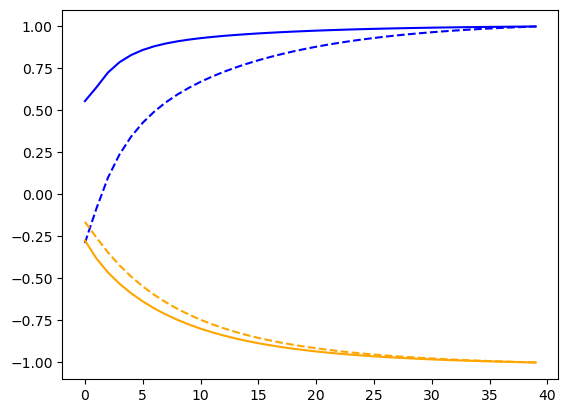

In [73]:

plt.plot(np.mean(target_activations_accessory[:,curve_length - 1,:],axis=-1)/np.max(np.abs(np.mean(target_activations_accessory[:,curve_length - 1,:],axis=-1))),color='b')
plt.plot(np.mean(target_activations_accessory[:,curve_length - 3,:],axis=-1)/np.max(np.abs(np.mean(target_activations_accessory[:,curve_length - 3,:],axis=-1))),linestyle='dashed',color='b')

plt.plot(np.mean(distractor_activations_accessory[:,curve_length - 1,:],axis=-1)/np.max(np.abs(np.mean(distractor_activations_accessory[:,curve_length - 1,:],axis=-1))),color='orange')
plt.plot(np.mean(distractor_activations_accessory[:,curve_length - 3,:],axis=-1)/np.max(np.abs(np.mean(distractor_activations_accessory[:,curve_length - 3,:],axis=-1))),linestyle='dashed',color='orange')
plt.ylim([-1.1,1.1])
#plt.legend(['0','1','2','3'])
